In [1]:
import pandas as pd
import numpy as np
import time
import sys
import matplotlib.pyplot as plt


In [2]:
sys.path.append("../../code/common/")

In [3]:
%matplotlib inline

In [4]:
df = pd.read_csv("../../data/hvac/minutes_a3.csv")

In [5]:
df.head()

,dataid,a1,a2,a3,a4,a5,a6,evening_energy,evening_gt,evening_mins,...,overall_energy,overall_mins,sleep_energy,sleep_gt,sleep_mins,sleep_pred,work_energy,work_gt,work_mins,work_pred
0,26,0.083661,0.024915,0.023174,0.047056,0.547471,-0.004836,8943400,78,3367,...,37621500,15644,17952200,76,7346,62.795464,3023910,82,1409,72.282705
1,94,0.016234,0.007606,0.006922,0.023032,0.006018,0.000434,1148050,77,990,...,7616560,7049,4461110,78,4051,60.000001,1181950,85,1187,67.310145
2,370,0.085960,0.030099,0.032852,0.053507,0.148778,0.019531,12506900,75,5215,...,49039000,22300,19882800,75,8750,60.000000,10344500,75,5142,69.694715
3,410,0.063527,0.038442,0.026456,0.046613,0.630663,-0.021199,5543070,80,1848,...,30089800,10549,14957200,76,5171,60.000000,2384120,84,893,69.766751
4,545,0.054759,0.013884,0.045675,0.072697,0.483499,0.012248,17545800,76,6430,...,52402400,20859,20820600,72,8083,60.000000,8734060,76,3853,77.026838


In [6]:
from common_functions import latexify, format_axes
latexify(columns=2, fig_height=3)

/Users/nipunbatra/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:855: UserWarning: text.fontsize is deprecated and replaced with font.size; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


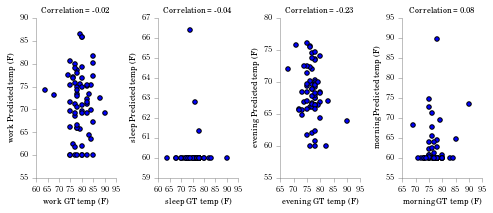

In [28]:
fig, ax = plt.subplots(ncols=4)
for i, time in enumerate(["work", "sleep", "evening", "morning"]):
    x = df["%s_gt" %time]
    y = df["%s_pred" %time]
    ax[i].scatter(x, y)
    ax[i].set_xlabel("%s GT temp (F)" %time)
    ax[i].set_ylabel("%s Predicted temp (F)" %time)
    ax[i].set_title("Correlation = %0.2f" %x.corr(y))
    format_axes(ax[i])
plt.tight_layout()
plt.savefig("../../figures/hvac/setpoint_prediction_correlation.png")
plt.savefig("../../figures/hvac/setpoint_prediction_correlation.pdf")


    


In [19]:
for time in ["work", "sleep", "evening", "morning"]:
    df["%s_setpoint_error" %time] = df["%s_gt" %time]-df["%s_pred" %time]

In [20]:
error_columns = [x for x in df.columns if "setpoint" in x]
error_columns

['work_setpoint_error',
 'sleep_setpoint_error',
 'evening_setpoint_error',
 'morning_setpoint_error']

In [27]:
from common_functions import latexify, format_axes

In [28]:
latexify(columns=1)

/Users/nipunbatra/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:855: UserWarning: text.fontsize is deprecated and replaced with font.size; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


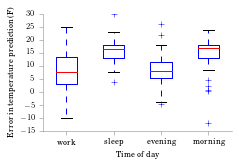

In [32]:
error_df = df[error_columns]
error_df.columns = [x.split("_")[0] for x in error_columns]
ax = error_df.plot(kind='box');
format_axes(ax)
plt.xlabel("Time of day")
plt.ylabel("Error in temperature prediction (F)")
plt.savefig("../../figures/hvac/setpoint_error.png")
plt.savefig("../../figures/hvac/setpoint_error.pdf")

In [15]:
df.evening_pred.head()

0    60.000001
1    74.491640
2    61.638673
3    66.900284
4    66.013915
Name: evening_pred, dtype: float64

In [16]:
df.work_pred.head()

0    72.282705
1    67.310145
2    69.694715
3    69.766751
4    77.026838
Name: work_pred, dtype: float64

In [17]:
df.work_gt.head()

0    82
1    85
2    75
3    84
4    76
Name: work_gt, dtype: float64

In [130]:
from itertools import chain, combinations

def powerset(iterable):
    xs = list(iterable)
    # note we return an iterator rather than a list
    N_max=5
    return chain.from_iterable( combinations(xs,n) for n in range(1, N_max))
    return chain.from_iterable( combinations(xs,n) for n in range(1, len(xs)+1))

In [131]:
features = ['sleep_pred','morning_pred','work_pred','evening_pred','a1','a2','a3','work_energy', 'sleep_energy', 'morning_energy', 
            'evening_energy','morning_mins', 'work_mins','sleep_mins', 'evening_mins','overall_energy', 'overall_mins']
features_small = ['sleep_pred','morning_pred','work_pred','evening_pred','a1','a2','a3']
features_mid = ['sleep_pred','morning_pred','work_pred','evening_pred','a1','a2','a3','work_energy','evening_energy','work_mins','evening_mins']

In [132]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

In [133]:
np.random.seed(42)


In [134]:
from sklearn import cross_validation
train_idx, test_idx = cross_validation.train_test_split(range(len(df)), train_size=0.5)
train_idx

[15,
 27,
 26,
 24,
 47,
 11,
 32,
 59,
 46,
 37,
 29,
 43,
 49,
 1,
 21,
 2,
 52,
 39,
 35,
 23,
 54,
 10,
 22,
 18,
 57,
 38,
 20,
 7,
 42,
 14,
 28,
 51]

In [135]:
train = df.ix[train_idx]
test = df.ix[test_idx]

In [136]:
pd.value_counts(train.hvac_class)

Bad        19
Average    11
Good        2
dtype: int64

In [137]:
pd.value_counts(test.hvac_class)

Bad        19
Average    11
Good        3
dtype: int64

In [158]:
out_fold1 = {}
out_fold2 = {}
y1_best_score = 0
y1_best_pred = None
y2_best_score = 0
y2_best_pred = None
best_random_state = -1
best_random_score = 0

for random_state in range(0,1):
    print random_state
    print time.time()
    cls = {  "RF":RandomForestClassifier()
          }
    out_fold1[random_state] = {"SVM":{}, "DT":{},"KNN":{},"RF":{}, "Ada":{}}



    for f in powerset(features):
        for cl_name, clf in cls.iteritems():
            clf.fit(train[list(f)], train["hvac_class"])
            y_pred = clf.predict(test[list(f)])
            y_true = test['hvac_class']
            accur = accuracy_score(y_pred, y_true)
            out_fold1[random_state][cl_name][f] = accur
            if accur>y1_best_score:
                y1_best_score=accur
                y1_best_pred = y_pred

    out_fold2[random_state] = {"SVM":{}, "DT":{},"KNN":{},"RF":{}, "Ada":{}}

    for f in powerset(features):
        for cl_name, clf in cls.iteritems():
            clf.fit(test[list(f)], test["hvac_class"])
            y_pred = clf.predict(train[list(f)])
            y_true =train['hvac_class']
            accur = accuracy_score(y_pred, y_true)
            out_fold2[random_state][cl_name][f] = accur
            if accur>y2_best_score:
                y2_best_score=accur
                y2_best_pred = y_pred
    
    if y2_best_score+y1_best_score>best_random_score:
        best_random_score=y2_best_score+y1_best_score
        best_random_state = random_state
            

        
    

0
1434899714.03


In [159]:
y2_best_score, y1_best_score, best_random_score, best_random_state

(0.71875, 0.72727272727272729, 1.4460227272727273, 0)

In [160]:
import operator
sorted_fold1 = sorted(out_fold1[1]["RF"].items(), key=operator.itemgetter(1))
sorted_fold2 = sorted(out_fold2[1]["RF"].items(), key=operator.itemgetter(1))

KeyError: 1

In [161]:
d = {}
for i in range(1):
    d[i] = ((pd.Series(out_fold1[i]["RF"])+pd.Series(out_fold2[i]["RF"]))/2).dropna()
    d[i].sort()
    print i, d[i].values[-1]
    

0 0.677083333333


In [162]:
d[0]

morning_pred  evening_pred    a1              overall_energy    0.293087
              a1              evening_mins    overall_mins      0.308712
                              a3              overall_mins      0.322917
              morning_energy  evening_mins    overall_mins      0.323390
evening_pred  a1              a3              evening_energy    0.323390
morning_pred  work_energy     sleep_mins      evening_mins      0.323390
work_pred     morning_energy  evening_mins    overall_mins      0.323390
morning_pred  a1              a3              evening_mins      0.324337
              a3              work_energy     evening_energy    0.324337
              evening_energy  sleep_mins      overall_energy    0.324811
evening_pred  a1              a2              morning_energy    0.337121
morning_pred  evening_energy  morning_mins    evening_mins      0.337595
sleep_pred    work_pred       a1              morning_mins      0.338068
morning_pred  work_pred       sleep_energy    eveni

In [164]:
d[0].index[-1]

('evening_pred', 'work_energy', 'work_mins', 'overall_mins')

In [156]:
feature_to_use = list(d[0].index.values[-1])
clf = RandomForestClassifier()
clf.fit(df.head(33)[feature_to_use], df.head(33)["hvac_class"])
pred_labels = clf.predict(df.tail(33)[feature_to_use])
true_labels = df.tail(33)["hvac_class"]
df_accuracy = pd.DataFrame({"pred":pred_labels, "true":true_labels.values})
print accuracy_score(pred_labels, true_labels)
d1 = pd.DataFrame(confusion_matrix(true_labels, pred_labels))
d1.columns = ["Average", "Bad", "Good"]
d1.index = ["Average", "Bad", "Good"]
d1

0.454545454545


,Average,Bad,Good
Average,6,5,0
Bad,11,9,0
Good,2,0,0


In [50]:
feature_to_use = list(d[2].index.values[-1])
clf = RandomForestClassifier(random_state=1)
clf.fit(df.tail(33)[feature_to_use], df.tail(33)["hvac_class"])
pred_labels = clf.predict(df.tail(33)[feature_to_use])
true_labels = df.head(33)["hvac_class"]
df_accuracy = pd.DataFrame({"pred":pred_labels, "true":true_labels.values})
print accuracy_score(pred_labels, true_labels)
d2 = pd.DataFrame(confusion_matrix(true_labels, pred_labels))
d2.columns = ["Average", "Bad", "Good"]
d2.index = ["Average", "Bad", "Good"]
d2

0.545454545455


,Average,Bad,Good
Average,5,6,0
Bad,6,12,1
Good,0,2,1


In [173]:
d1+d2

,Average,Bad,Good
Average,7,15,0
Bad,8,30,1
Good,0,4,1


In [159]:
feature_to_use

['morning_pred', 'a3', 'morning_mins', 'evening_mins']

In [138]:
clf.fit(df_res.head(32)[['work_energy', 'sleep_energy', 'morning_energy', 'evening_energy']], df_res.head(32)["hvac_class"])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')

In [139]:
o = clf.predict(df_res.tail(33)[['work_energy', 'sleep_energy', 'morning_energy', 'evening_energy']])

In [140]:
o

array(['Good', 'Bad', 'Average', 'Good', 'Bad', 'Good', 'Average', 'Good',
       'Bad', 'Good', 'Bad', 'Good', 'Good', 'Bad', 'Bad', 'Good',
       'Average', 'Good', 'Good', 'Good', 'Bad', 'Good', 'Bad', 'Good',
       'Bad', 'Bad', 'Bad', 'Bad', 'Average', 'Bad', 'Bad', 'Bad', 'Good'], dtype=object)

In [157]:
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score

In [142]:
y_true = df_res.tail(33)["hvac_class"]
y_pred = o

In [145]:
precision_score(y_true, y_pred)

/Users/nipunbatra/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)


0.48124098124098119

In [143]:
confusion_matrix(y_true, y_pred)

array([[ 1,  2,  5],
       [ 2, 10,  4],
       [ 1,  3,  5]])

In [49]:
svr = LinearSVR()

In [83]:
svr.fit(df_res[['overall_mins', 'overall_energy', 'work_energy']], df_res['good_count'])

LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0)

In [84]:
o=svr.predict(df_res[['overall_mins', 'overall_energy', 'work_energy']])

In [85]:
np.round(o)

array([ 102.,   77.,   46.,   65.,   90.,   64.,   77.,   40.,   53.,
         56.,   81.,  114.,   80.,   60.,  113.,   74.,   49.,   94.,
         21.,  107.,   85.,  153.,   16.,   56.,   71.,  110.,  110.,
         83.,   65.,   96.,   64.,   64.,   34.,   36.,  105.,  225.,
         48.,   86.,   30.,   84.,   35.,   98.,   65.,   54.,   41.,
         58.,   57.,   16.,   43.,   75.,   55.,   39.,   50.,  156.,
         66.,  123.,   44.,   89.,    4.,   22.,  153.,  176.,   97.,
        166.,   93.,   33.])

In [56]:
import matplotlib.pyplot as plt

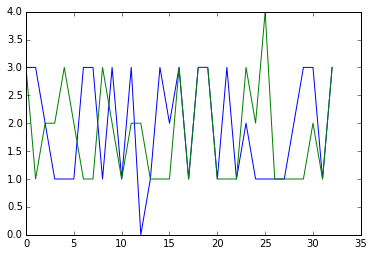

In [99]:
plt.plot(np.round(o))
plt.plot(df_res.tail(33)['good_count'])

In [58]:
%matplotlib inline

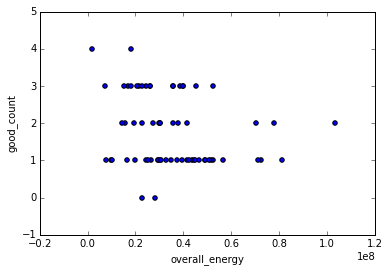

In [64]:
df_res.plot(kind="scatter", x="overall_energy", y="good_count")